In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from google.colab import drive
from nltk.tokenize import RegexpTokenizer
# KERAS
import tensorflow as tf
from tensorflow import keras
from keras.losses import CategoricalCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
tag_df_processed = pd.read_csv('gdrive/MyDrive/save_file/data_tag_processed_20220124.csv')

In [3]:
tag_df_processed

,Document_No,value,tag
0,0,toko belanja online,5
1,1,beli power bank kualitas pdhl ngecas handphone...,3
2,2,kerennn bikin ribet,3
3,3,aplikasi belanja online,5
4,4,mudah belanja,5
...,...,...,...
759388,759388,aplikasimya bagusss,4
759389,759389,produk import asli hoki untung,2
759390,759390,bantu belanja online,5
759391,759391,belanja rumah cocok kaum mageran,5


In [4]:
tokenizer_data = RegexpTokenizer(r'\w+')
tag_df_processed['value_tokenize'] = tag_df_processed['value'].map(tokenizer_data.tokenize)

In [5]:
value = tag_df_processed["value_tokenize"]
tags = tag_df_processed["tag"]

## LSTM

In [6]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(value)
seq = tokenizer.texts_to_sequences(value)
X = pad_sequences(seq, padding = 'post')

print('X_shape: ', X.shape)
print('X_min: ', np.min(X))
print('X_max: ', np.max(X))

X_shape:  (759393, 70)
X_min:  0
X_max:  9999


In [7]:
y = pd.DataFrame(pd.get_dummies(tags))

In [8]:
from sklearn.model_selection import train_test_split

x_train_valid, x_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=42)

In [9]:
y_train

,0,1,2,3,4,5,6
144147,0,0,0,0,0,0,1
322455,0,0,1,0,0,0,0
377956,0,0,0,0,0,0,1
215089,0,0,1,0,0,0,0
347643,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
660514,0,0,0,0,0,0,1
427961,0,0,0,1,0,0,0
211825,0,0,1,0,0,0,0
250600,0,0,0,0,0,0,1


In [10]:
embed_size = 64
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim = 10000, output_dim=embed_size, input_shape = [None], trainable=False, mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(7, activation = 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                                 
Total params: 673,479
Trainable params: 33,479
Non-trainable params: 640,000
_________________________________________________________________


In [11]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_valid, y_valid))

Epoch 1/5
15188/15188 [==============================] - 1076s 70ms/step - loss: 1.1465 - accuracy: 0.5983 - val_loss: 0.9928 - val_accuracy: 0.6511
Epoch 2/5
15188/15188 [==============================] - 1043s 69ms/step - loss: 0.9132 - accuracy: 0.6788 - val_loss: 0.8387 - val_accuracy: 0.7065
Epoch 3/5
15188/15188 [==============================] - 1042s 69ms/step - loss: 0.7939 - accuracy: 0.7222 - val_loss: 0.7560 - val_accuracy: 0.7379
Epoch 4/5
15188/15188 [==============================] - 1042s 69ms/step - loss: 0.7240 - accuracy: 0.7468 - val_loss: 0.7147 - val_accuracy: 0.7522
Epoch 5/5
15188/15188 [==============================] - 1035s 68ms/step - loss: 0.6775 - accuracy: 0.7639 - val_loss: 0.6651 - val_accuracy: 0.7697


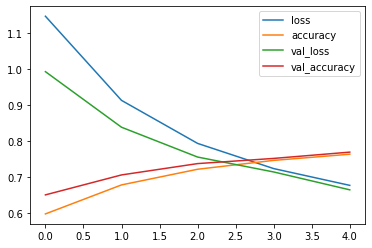

In [12]:
pd.DataFrame(history.history).plot()

In [13]:
y_pred = np.argmax(model.predict(x_test), axis=-1)

In [14]:
y_test = np.argmax(y_test.to_numpy(), axis=1)

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81     21938
           1       0.81      0.86      0.83     22884
           2       0.75      0.79      0.77     21291
           3       0.66      0.70      0.68     17986
           4       0.67      0.58      0.62     12970
           5       0.81      0.82      0.82     24022
           6       0.76      0.76      0.76     30788

    accuracy                           0.77    151879
   macro avg       0.76      0.76      0.76    151879
weighted avg       0.77      0.77      0.77    151879



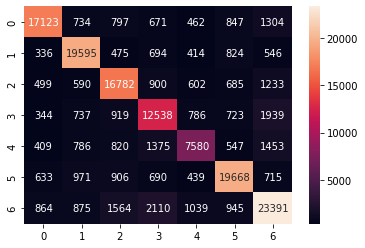

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f')

In [ ]:
model.save('lstm.h5')